# Package Imports

In [1]:
# Package Imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, ReLU, ZeroPadding2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Dense, Concatenate, AveragePooling2D

import numpy as np
print(tf.__version__) 

2.12.0


# Create the Model (Inception V3)

In [2]:
# ============================================================================== #

# ````````````````````````````` Model creation `````````````````````````````
# You can replace this section with other models from here: 
# https://github.com/melvincabatuan/keras-idiomatic-programmer/tree/master/zoo 

# Inception v2 (Inception-BN)
# Paper: https://arxiv.org/pdf/1409.4842.pdf

# The Inception deep convolutional architecture was introduced as GoogLeNet in (Szegedy et al. 2015a), here named Inception-v1. 
# Later the Inception architecture was refined in various ways, first by the introduction of batch normalization (Ioffe and Szegedy 2015) (Inception-v2). 
# Later by additional factorization ideas in the third iteration (Szegedy et al. 2015b) which will be referred to as Inception-v3.


# ============================================================================== #

def stem(inputs):
    """ Construct the Stem Convolutional Group 
        inputs : the input vector
    """
    # Coarse filter of V1 (7x7) factorized into 3 3x3.
    # First 3x3 convolution is strided
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # Third 3x3, filters are doubled and padding added
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Pooled feature maps will be reduced by 75%
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # 3x3 reduction
    x = Conv2D(80, (1, 1), strides=(1, 1), padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # Dimensionality expansion
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Pooled feature maps will be reduced by 75%
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    return x

def group(x, blocks, inception=None, reduction=None, n_classes=0):
    """ Construct an Inception group
        x         : input into the group
        blocks    : filters for each block in the group
        inception : type of inception block
        reduction : whether to end the group with grid reduction
        n_classes : number of classes for auxiliary classifier
    """
    aux = [] # Auxiliary Outputs

    # Construct the inception blocks (modules)
    for block in blocks:
        x = inception(x, block[0], block[1], block[2], block[3])           

    # Add auxiliary classifier
    if n_classes:
        aux.append(auxiliary(x, n_classes))
    
    # Add grid reduction
    if reduction:
        x = reduction(x)

    return x, aux

def inception_block_A(x, f1x1, f3x3, f5x5, fpool):
    """ Construct an Inception block 35x35 (module)
        x    : input to the block
        f1x1 : filters for 1x1 branch
        f3x3 : filters for 3x3 branch
        f5x5 : filters for 5x5 branch
        fpool: filters for pooling branch
    """
    # 1x1 branch
    b1x1 = Conv2D(f1x1[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b1x1 = BatchNormalization()(b1x1)
    b1x1 = ReLU()(b1x1)

    # double 3x3 branch
    # 3x3 reduction
    b3x3 = Conv2D(f3x3[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)
    b3x3 = Conv2D(f3x3[1], (3, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)
    b3x3 = Conv2D(f3x3[1], (3, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)

    # 5x5 branch
    # 5x5 reduction
    b5x5 = Conv2D(f5x5[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b5x5 = BatchNormalization()(b5x5)
    b5x5 = ReLU()(b5x5)
    b5x5 = Conv2D(f5x5[1], (3, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b5x5)
    b5x5 = BatchNormalization()(b5x5)
    b5x5 = ReLU()(b5x5)

    # Pooling branch
    bpool = AveragePooling2D((3, 3), strides=1, padding='same')(x)
    # 1x1 projection
    bpool = Conv2D(fpool[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(bpool)
    bpool = BatchNormalization()(bpool)
    bpool = ReLU()(bpool)

    # Concatenate the outputs (filters) of the branches
    x = Concatenate()([b1x1, b3x3, b5x5, bpool])
    return x

def inception_block_B(x, f1x1, f7x7, f7x7dbl, fpool):
    """ Construct an Inception block 17x17 (module)
        x      : input to the block
        f1x1   : filters for 1x1 branch
        f7x7   : filters for 7x7 factorized asn 1x7, 7x1 branch
        f7x7dbl: filters for double 7x7 factorized as 1x7, 7x1 branch
        fpool  : filters for pooling branch
    """ 
    # 1x1 branch
    b1x1 = Conv2D(f1x1[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b1x1 = BatchNormalization()(b1x1)
    b1x1 = ReLU()(b1x1)
    
    # 7x7 branch
    # 7x7 reduction
    b7x7 = Conv2D(f7x7[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)
    # factorized 7x7
    b7x7 = Conv2D(f7x7[1], (1, 7), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)
    b7x7 = Conv2D(f7x7[2], (7, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)

    # double 7x7 branch
    # 7x7 reduction
    b7x7dbl = Conv2D(f7x7dbl[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b7x7dbl = BatchNormalization()(b7x7dbl)
    b7x7dbl = ReLU()(b7x7dbl)
    # factorized 7x7
    b7x7dbl = Conv2D(f7x7dbl[1], (1, 7), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7dbl)
    b7x7dbl = BatchNormalization()(b7x7dbl)
    b7x7dbl = ReLU()(b7x7dbl)
    b7x7dbl = Conv2D(f7x7dbl[2], (7, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7dbl)
    b7x7dbl = BatchNormalization()(b7x7dbl)
    b7x7dbl = ReLU()(b7x7dbl)
    b7x7dbl = Conv2D(f7x7dbl[3], (1, 7), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7dbl)
    b7x7dbl = BatchNormalization()(b7x7dbl)
    b7x7dbl = ReLU()(b7x7dbl)
    b7x7dbl = Conv2D(f7x7dbl[4], (7, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7dbl)
    b7x7dbl = BatchNormalization()(b7x7dbl)
    b7x7dbl = ReLU()(b7x7dbl)

    # Pooling branch
    bpool = AveragePooling2D((3, 3), strides=1, padding='same')(x)
    # 1x1 projection
    bpool = Conv2D(fpool[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(bpool)
    bpool = BatchNormalization()(bpool)
    bpool = ReLU()(bpool)

    # Concatenate the outputs (filters) of the branches
    x = Concatenate()([b1x1, b7x7, b7x7dbl, bpool])
    return x

def inception_block_C(x, f1x1, f3x3, f3x3dbl, fpool):
    """ Construct an Inception block 8x8 (module)
        x      : input to the block
        f1x1   : filters for 1x1 branch
        f3x3   : filters for 3x3 factorized asn 1x3, 3x1 branch
        f3x3dbl: filters for double 3x3 factorized as 1x3, 3x1 branch
        fpool  : filters for pooling branch
    """ 
    # 1x1 branch
    b1x1 = Conv2D(f1x1[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b1x1 = BatchNormalization()(b1x1)
    b1x1 = ReLU()(b1x1)
    
    # 3x3 branch
    # 3x3 reduction
    b3x3 = Conv2D(f3x3[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)
    # Split
    b3x3_1 = Conv2D(f3x3[0], (1, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3)
    b3x3_1 = BatchNormalization()(b3x3_1)
    b3x3_1 = ReLU()(b3x3_1)
    b3x3_2 = Conv2D(f3x3[1], (3, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3)
    b3x3_2 = BatchNormalization()(b3x3_2)
    b3x3_2 = ReLU()(b3x3_2)
    # Merge
    b3x3   = Concatenate()([b3x3_1, b3x3_2])
    
    # double 3x3 branch
    # 3x3 reduction
    b3x3dbl = Conv2D(f3x3dbl[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b3x3dbl = BatchNormalization()(b3x3dbl)
    b3x3dbl = ReLU()(b3x3dbl)
    b3x3dbl = Conv2D(f3x3dbl[1], (3, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3dbl)
    b3x3dbl = BatchNormalization()(b3x3dbl)
    b3x3dbl = ReLU()(b3x3dbl)
    # Split
    b3x3dbl_1 = Conv2D(f3x3dbl[2], (1, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3dbl)
    b3x3dbl_1 = BatchNormalization()(b3x3dbl_1)
    b3x3dbl_1 = ReLU()(b3x3dbl_1)
    b3x3dbl_2 = Conv2D(f3x3dbl[3], (3, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3dbl)
    b3x3dbl_2 = BatchNormalization()(b3x3dbl_2)
    b3x3dbl_2 = ReLU()(b3x3dbl_2)
    # Merge
    b3x3dbl   = Concatenate()([b3x3dbl_1, b3x3dbl_2])

    # Pooling branch
    bpool = AveragePooling2D((3, 3), strides=1, padding='same')(x)
    # 1x1 projection
    bpool = Conv2D(fpool[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(bpool)
    bpool = BatchNormalization()(bpool)
    bpool = ReLU()(bpool)

    # Concatenate the outputs (filters) of the branches
    x = Concatenate()([b1x1, b3x3, b3x3dbl, bpool])
    return x

def grid_reduction_A(x, f3x3=384, f3x3dbl=(64, 96, 96)):
    """ Construct the Grid Reduction block
        x       : input to the block
        f3x3    : filter size for 3x3 branch
        f3x3dbl : filter sizes for double 3x3 branch
    """
    # 3x3 branch
    # grid reduction
    b3x3 = Conv2D(f3x3, (3, 3), strides=2, padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)

    # double 3x3 branch
    # 3x3 reduction
    b3x3dbl = Conv2D(f3x3dbl[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b3x3dbl = BatchNormalization()(b3x3dbl)
    b3x3dbl = ReLU()(b3x3dbl)
    b3x3dbl = Conv2D(f3x3dbl[1], (3, 3), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b3x3dbl)
    b3x3dbl = BatchNormalization()(b3x3dbl)
    b3x3dbl = ReLU()(b3x3dbl)
    # grid reduction
    b3x3dbl = Conv2D(f3x3dbl[1], (3, 3), strides=2, padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(b3x3dbl)
    b3x3dbl = BatchNormalization()(b3x3dbl)
    b3x3dbl = ReLU()(b3x3dbl)

    # pool branch
    bpool   = MaxPooling2D((3, 3), strides=2)(x)

    # Concatenate the outputs (filters) of the branches
    x = Concatenate()([b3x3, b3x3dbl, bpool])
    return x

def grid_reduction_B(x, f3x3=(192, 320), f7x7=(192, 192, 192, 192)):
    """ Construct the Grid Reduction block
        x       : input to the block
        f3x3    : filter size for 3x3 branch
        f7x7    : filter sizes for 7x7 + 3x3 branch
    """
    # 3x3 branch
    # 3x3 reduction
    b3x3 = Conv2D(f3x3[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)
    # grid reduction
    b3x3 = Conv2D(f3x3[1], (3, 3), strides=2, padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(b3x3)
    b3x3 = BatchNormalization()(b3x3)
    b3x3 = ReLU()(b3x3)

    # 7x7 (factorized as 1x7, 7x1) + 3x3 branch
    # 7x7 reduction
    b7x7 = Conv2D(f7x7[0], (1, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(x)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)
    b7x7 = Conv2D(f7x7[1], (1, 7), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)
    b7x7 = Conv2D(f7x7[2], (7, 1), strides=1, padding='same', use_bias=False, kernel_initializer='glorot_uniform')(b7x7)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)
    # grid reduction
    b7x7 = Conv2D(f7x7[3], (3, 3), strides=2, padding='valid', use_bias=False, kernel_initializer='glorot_uniform')(b7x7)
    b7x7 = BatchNormalization()(b7x7)
    b7x7 = ReLU()(b7x7)

    # pool branch
    bpool   = MaxPooling2D((3, 3), strides=2)(x)

    # Concatenate the outputs (filters) of the branches
    x = Concatenate()([b3x3, b7x7, bpool])
    return x
    
def learner(x, n_classes):
    """ Construct the Learner
        x        : input to the learner
        n_classes: number of output classes
    """
    aux = [] # Auxiliary Outputs

    # Group A (35x35)
    x, o = group(x, [((64,), (64, 96), (48, 64), (32,)),
                     ((64,), (64, 96), (48, 64), (64,)),
                     ((64,), (64, 96), (48, 64), (64,))
                    ], inception=inception_block_A, reduction=grid_reduction_A) 
    aux += o

    # Group B (17x17)
    x, o = group(x, [((192,), (128, 128, 192), (128, 128, 128, 128, 192), (192,)),
                     ((192,), (160, 160, 192), (160, 160, 160, 160, 192), (192,)),
                     ((192,), (160, 160, 192), (160, 160, 160, 160, 192), (192,)),
                     ((192,), (192, 192, 192), (192, 192, 192, 192, 192), (192,))
                    ], inception=inception_block_B, reduction=grid_reduction_B, n_classes=n_classes) 
    aux += o

    # Group C (8x8)
    x, o = group(x, [((320,), (384, 384, 384), (448, 384, 384, 384), (192,)),
                     ((320,), (384, 384, 384), (448, 384, 384, 384), (192,))
                    ], inception=inception_block_C) 
    aux += o
    return x, aux
    
def auxiliary(x, n_classes):
    """ Construct the auxiliary classier
        x        : input to the auxiliary classifier
        n_classes: number of output classes
    """
    x = AveragePooling2D((5, 5), strides=(3, 3))(x)
    x = Conv2D(128, (1, 1), strides=(1, 1), use_bias=False, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    # filter will be 5x5 for V3
    x = Conv2D(768, x.shape[1:3].as_list(), strides=(1, 1), use_bias=False, kernel_initializer='glorot_uniform')(x)
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)
    return output

def classifier(x, n_classes, dropout=0.4):
    """ Construct the Classifier Group 
        x         : input to the classifier
        n_classes : number of output classes
        dropout   : percentage for dropout rate
    """
    # Pool at the end of all the convolutional residual blocks
    # Will be 8x8 in V3
    x = AveragePooling2D(x.shape[1:3].as_list())(x)
    x = Dropout(dropout)(x)
    x = Flatten()(x)

    # Final Dense Outputting Layer for the outputs
    outputs = Dense(n_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)
    return outputs

## Model Instantiation

In [3]:
# Model

NUM_CLASSES = 10

def get_model(input_shape): # e.g. (224, 224, 3) 

    # Meta-parameter: percent of dropout
    dropout = 0.4

    # The input tensor (299x299 in V3 vs 224x224 in V1/V2)
    inputs = Input(shape=(299, 299, 3))

    # The stem convolutional group
    x = stem(inputs)

    # The learner
    x, aux = learner(x, 1000)

    # The classifier for 1000 classes
    outputs = classifier(x, 1000)

    # Instantiate the Model
    model = Model(inputs, [outputs] + aux)

    return model

## Model Compilation

In [12]:
# Prepare the model
input_shape = (299, 299, 3)
model = get_model(input_shape)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Model Summary

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Visualize the model

In [6]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png')

Output hidden; open in https://colab.research.google.com to view.

# Preparing the dataset

CIFAR10 small images classification dataset is composed of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. See more info at the CIFAR homepage ( https://www.cs.toronto.edu/~kriz/cifar.html ).

The classes are:

| Label |	Description |
|---|---|
|0 	| airplane |
|1 	|automobile|
|2 	|bird|
|3 	|cat|
|4 	|deer|
|5 	|dog|
|6 	|frog|
|7 	|horse|
|8 	|ship|
|9 	|truck|

Link: https://keras.io/api/datasets/cifar10/ 

In [7]:
from tensorflow.keras.datasets import cifar10

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Reshape and normalize images
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

In [8]:
test_labels.shape

(10000, 1)

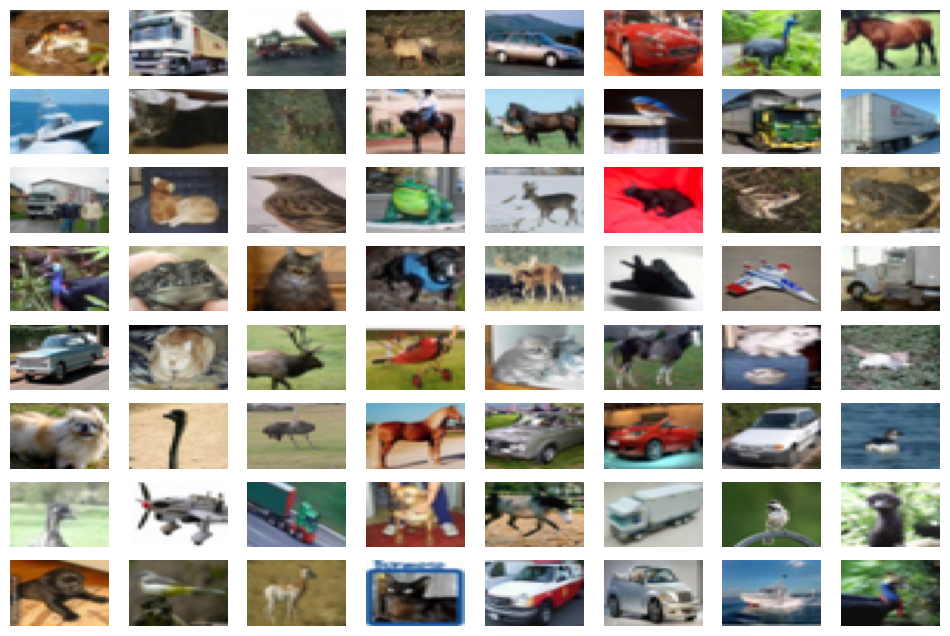

In [9]:
# Visualize the dataset

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

count = 8
fig, ax = plt.subplots(count, count)
k = 0
for i in range(count):
    for j in range(count):
        ax[i][j].imshow(train_images[k], aspect='auto')
        ax[i][j].axis('off')
        k += 1
 
plt.show()

# Training

In [10]:
#create callback; documentation: https://keras.io/api/callbacks/

filepath = 'best_model.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

stop_early = keras.callbacks.EarlyStopping(patience=10)

In [13]:
# Logging with tensorboard
tensorboard = keras.callbacks.TensorBoard(
    log_dir="./log_directory",
)

# Train
epochs = 30
result = model.fit(train_images, 
          train_labels,
          epochs=epochs,  
          batch_size=128,
          validation_data=(test_images, test_labels),
         callbacks=[tensorboard])

Epoch 1/30


ValueError: ignored

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir  log_directory

## Results

In [ ]:
# Plot accuracy per iteration with Matplotlib

plt.plot(result.history['accuracy'], label='acc',)
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.grid()
plt.legend()

In [ ]:
# label mapping
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def infer(image_number):
    # image_number - select the image from our test dataset
   
    # display the image
    plt.imshow(test_images[image_number]) 
    # load the image in an array
    n = np.array(test_images[image_number])
    # reshape it
    p = n.reshape(1, 32, 32, 3)
    # pass in the network for prediction and
    # save the predicted label
    predicted_label = labels[model.predict(p).argmax()]
    # load the original label
    true_label = labels[int(test_labels[image_number])]
    # display the result
    print(f"Ground truth: {true_label}; Predicted: {predicted_label}" )

infer(0)

In [ ]:
# Here are a few test images

count = 8
fig, ax = plt.subplots(count, count)
k = 0
for i in range(count):
    for j in range(count):
        ax[i][j].imshow(test_images[k], aspect='auto')
        ax[i][j].axis('off')
        k += 1
 
plt.show()

In [ ]:
infer(4)

In [ ]:
infer(5)

# Performance Metrics

## Training-Validation Plots

In [ ]:
# Plot accuracy and loss with Matplotlib

epochs = epochs
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


test_predictions =  np.argmax(model.predict(test_images), axis=1)
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_predictions, target_names=labels))